In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

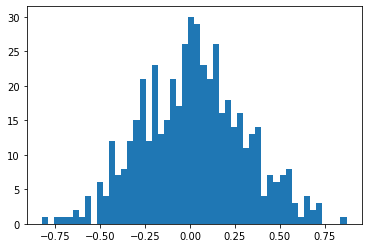

In [2]:
# https://stackoverflow.com/questions/36894191/how-to-get-a-normal-distribution-within-a-range-in-numpy
def get_truncated_normal(mean=0, sd=0.3, low=-1, upp=1):
    return truncnorm(
        (low - mean)/sd, 
        (upp - mean)/sd, 
        loc = mean, 
        scale = sd)

X = get_truncated_normal()
plt.hist(X.rvs(500), bins = 50)
plt.show()

In [3]:
class post:
    
    def __init__(self, user_id, kind, user_ideology, user_trust):
        self.type = kind   # binary: either post (1) or comment (0)
        self.author = user_id
        
        # post's ideology score
        self.ideology = get_truncated_normal(mean=user_ideology, sd=0.2, low=-1, upp=1).rvs()  
        
        # post's trustworthiness
        self.trust = get_truncated_normal(mean=user_trust, sd=0.1, low=0, upp=1).rvs()  

In [4]:
class user:
    def __init__(self):
        self.ideology = get_truncated_normal(mean=0, sd=0.3, low=-1, upp=1).rvs()
        # care value is dependent on the absolute value of ideology value of the user + noise,
        # on the assumption based on research that reveals people with more radial political leanings tend to be more engaging
        self.care = get_truncated_normal(mean=abs(self.ideology), sd = 0.15, low = 0, upp=1).rvs()
        self.trust = get_truncated_normal(mean=0.5, sd=0.15, low=0, upp=1).rvs()   # post's trustworthiness
        
        # in a number of iterations, if the user reads more than this percentage of posts which ideology distance 
        #   between the user and the post is more than 1.2, the user will quit using the platform
        self.tolerance = 1 - self.care
        # the number of "bad" post that the user hate (ideology distance > 1.2) 
        #   that will make the user leave the platform 
        self.bad_posts = 0
        self.max_bad_posts = 10
        
        # how many posts the user has read
        self.num_posts_read = 0
        
        # how easy a user will be influenced/persuaded by a post, which is determined by the ideology, where
        #   a right-wing user will be more difficult to influence than a left-wing user
        if(self.ideology < 0.5):
            self.easiness = get_truncated_normal(mean=0.5, sd = 0.15, low = 0, upp=1).rvs()
        else:
            self.easiness = get_truncated_normal(mean=0.25, sd = 0.15, low = 0, upp=1).rvs()
        
def create_n_users (n):
    user_list = []
    for i in range(n):
        user_list.append(user())
    return user_list

In [5]:
def create_posts(users):
    post_list = []
    for j in range(len(users)):
        user = users[j]
        num_posts = int(round((abs(user.ideology)*10)+(user.care*10), 0))
        for i in range(num_posts):
            post_list.append(post(j, 1, user.ideology, user.trust))
        #print(num_posts, user.care, user.ideology)
    return post_list

#user_list = create_n_users(100)
#post_list = create_posts(user_list)

#user_idx = 0
#for i in range(len(user_list)):
  #print("===== User", i, "=====")
  #num_posts = int(round((abs(user_list[i].ideology)*10)+(user_list[i].care*10), 0))
  #print("user's ideology score: ", user_list[i].ideology, ", user's care score: ", user_list[i].care, "# posts:", num_posts)

  #for j in range(num_posts):
  #  post_list.append(post(i, 1, user_list[i].ideology, user_list[i].trust))
  #  print("post", j, ": author =", post_list[-1].author, 
  #        ", post's ideology score =", post_list[-1].ideology, 
  #        ", post's trust score =", post_list[-1].trust)
  
  #print()

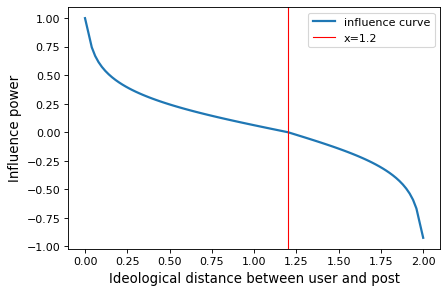

In [6]:
import math

# cutoff_point: when the ideology distance is greater than 1+notwork_point,
#   the user's ideology will be pulled further away from the post's ideology
# I use the formula below to make the influence effect between -1 and 1.
#   ref: https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
def logit(x, cutoff_pt=1.2, offset_power=2):
    if(x == 0):
        x = x+10**(-offset_power)
    elif(x == 2):
        x = x-10**(-offset_power)
        
    if(x <= cutoff_pt):
        x = (x/cutoff_pt)/2
    else:
        x = (((x-cutoff_pt)/(2-cutoff_pt))+1)/2
    
    return -math.log(x/(1-x))

# I use the formula below to make the influence effect between -1 and 1.
#   ref: https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
def normalize(value):
    max_value = logit(0)
    #min_value = logit(2)
    min_value = -max_value
    
    return_value = 2*((logit(value) - min_value)/(max_value - min_value)) -1
    if(return_value > 1):
        return 1
    elif(return_value < -1):
        return -1
    else:
        return return_value

# calculate how each post the user has read will affect the user's ideology
# - the affect power is inverse proportional to the distance between the user's and the post's ideology
# - use user's easiness parameter (between 0 and 1) to tune the influence effect  
# return value: new user ideology score
#def influence(user, post, tune_power=1.1, tune_denominator=0.1):
def influence(user, post):
    ideology_distance = abs(user.ideology - post.ideology)
    #print(ideology_distance, user.ideology, post.ideology)
    influence_ratio = user.easiness * normalize(ideology_distance)
    new_user_ideology = user.ideology - influence_ratio*(user.ideology - post.ideology)
    if(new_user_ideology > 1):
        return 1
    if(new_user_ideology < -1):
        return -1
    
    return new_user_ideology 

# for testing purpose
x = []
for i in range(101):
    x.append(i*2/100)
    
y = []
for i in range(101):
    y.append(normalize(x[i]))

plt.figure(figsize=(6, 4), dpi=80)
plt.xlabel("Ideological distance between user and post", fontsize=12)
plt.ylabel("Influence power", fontsize=12)
plt.plot(x, y, linewidth=2.0, label="influence curve")
plt.axvline(x=1.2, color="red", linewidth=1.0, label="x=1.2")
plt.legend()

#print(user_list[0].ideology, 
#      post_list[0].ideology, 
#      abs(user_list[0].ideology - post_list[0].ideology),
#      user_list[0].easiness)
#print(influence(user_list[0], post_list[0]))
#print(normalize(0.5))

In [7]:
def recommend_n_by_user_post (posts, users, n):
    #aggregate each post.ideology by users
    user_all_posts = {}
    for post in posts:
        if post.author not in user_all_posts.keys():
            user_all_posts[post.author] = []
        user_all_posts[post.author].append(post.ideology)
    
    #populate the user - ideology mean dictionary
    user_ideology_from_posts = {}
    index = 0
    for user in users:
        if index in user_all_posts.keys():
            user_ideology_from_posts[user] = sum(user_all_posts[index])/len(user_all_posts[index])
        else:
            user_ideology_from_posts[user] = 0
        index += 1
   
    
    recommended_posts = {}
    index = 0
    for user in users:
        diff = {}
        for post in posts:
            if not post.author == index:
                diff[post] = abs(user_ideology_from_posts[user] - post.ideology)
        new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
        result = list(new_diff.keys())
        new_result = []
        for i in range(n):
            new_result.append(result[i])
        recommended_posts[user] = new_result
        index += 1
    return recommended_posts

In [8]:
def recommend_n_random (posts, users, n):
    user_post = {}
    index = 0
    for user in users:
        if user not in user_post.keys():
            user_post[user] = []
            while len(user_post[user]) < n:
                r = random.choice(posts)
                if (not r.author == index) and (r not in user_post[user]):
                    user_post[user].append(r)
        index += 1
    return user_post

In [9]:
def recommend_n_opposite (posts, users, n):
    #aggregate each post.ideology by users
    user_all_posts = {}
    for post in posts:
        if post.author not in user_all_posts.keys():
            user_all_posts[post.author] = []
        user_all_posts[post.author].append(post.ideology)
    
    #populate the user - ideology mean dictionary
    user_ideology_from_posts = {}
    index = 0
    for user in users:
        if index in user_all_posts.keys():
            user_ideology_from_posts[user] = sum(user_all_posts[index])/len(user_all_posts[index])
        else:
            user_ideology_from_posts[user] = 0
        index += 1
   
    recommended_posts = {}
    index = 0
    for user in users:
        diff = {}
        for post in posts:
            if not post.author == index:
                diff[post] = abs(user_ideology_from_posts[user] - post.ideology)
        new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
        new_diff_1 = list(new_diff.keys())
        result = list(filter(lambda x : x.ideology * user_ideology_from_posts[user] <= 0, new_diff_1))
        new_result = []
        for i in range(n):
            new_result.append(result[len(result) - 1 - i])
        recommended_posts[user] = new_result
        index += 1
    return recommended_posts

In [20]:
def recommend_n_accordingly (posts, users, n):
    #aggregate each post.ideology by users
    user_all_posts = {}
    for post in posts:
        if post.author not in user_all_posts.keys():
            user_all_posts[post.author] = []
        user_all_posts[post.author].append(post.ideology)
    
    #populate the user - ideology mean dictionary
    user_ideology_from_posts = {}
    index = 0
    for user in users:
        if index in user_all_posts.keys():
            user_ideology_from_posts[user] = sum(user_all_posts[index])/len(user_all_posts[index])
        else:
            user_ideology_from_posts[user] = 0
        index += 1
   
    recommended_posts = {}
    index = 0
    for user in users:
        diff = {}
        for post in posts:
            if not post.author == index:
                diff[post] = abs(user_ideology_from_posts[user] - post.ideology)
        user_val = abs(user_ideology_from_posts[user])
        if user_val < 1/3:
            new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
            result = list(new_diff.keys())
            new_result = []
            for i in range(n):
                new_result.append(result[i])
            recommended_posts[user] = new_result
        elif user_val < 2/3:
            new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
            result = list(new_diff.keys())
            new_result = []
            for i in range(int(n/2)):
                new_result.append(result[i])
            new_diff_1 = list(new_diff.keys())
            result = list(filter(lambda x : x.ideology * user_ideology_from_posts[user] <= 0, new_diff_1))
            for i in range(n - int(n/2)):
                new_result.append(result[i])
            recommended_posts[user] = new_result
        else:
            new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
            new_diff_1 = list(new_diff.keys())
            result = list(filter(lambda x : x.ideology * user_ideology_from_posts[user] <= 0, new_diff_1))
            new_result = []
            for i in range(n):
                new_result.append(result[i])
            recommended_posts[user] = new_result
        index += 1
    return recommended_posts

*********** Simulating 100 users ***********


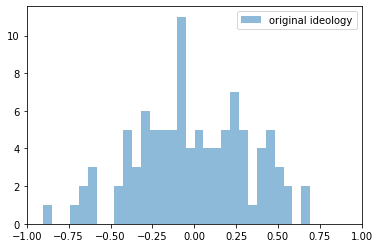

Original ideology mean & standard deviation: -0.008956, 0.335159

=== 1: recommend_n_by_user_post ===
After iteration #20:


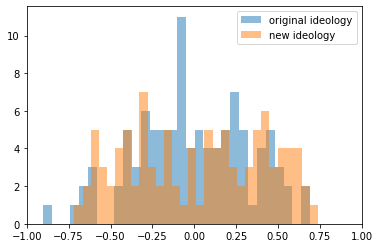

Current ideology mean & standard deviation: 0.023769, 0.402089

After iteration #50:


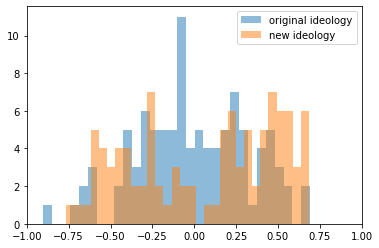

Current ideology mean & standard deviation: 0.069505, 0.430697

After iteration #100:


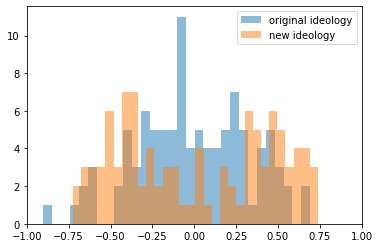

Current ideology mean & standard deviation: 0.012784, 0.447318

0 users have left

=== 2: recommend_n_random ===
After iteration #20:


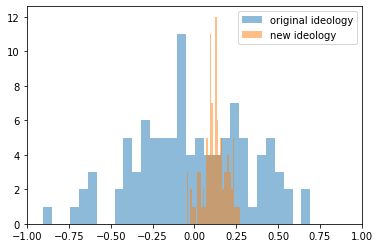

Current ideology mean & standard deviation: 0.123393, 0.068789

After iteration #50:


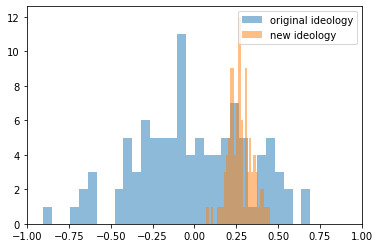

Current ideology mean & standard deviation: 0.273165, 0.071354

After iteration #100:


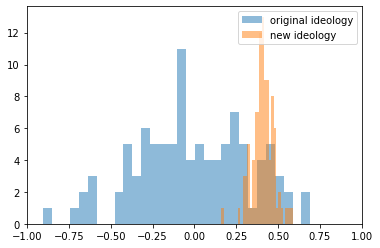

Current ideology mean & standard deviation: 0.408314, 0.064510

0 users have left

=== 3: recommend_n_opposite ===
After iteration #20:


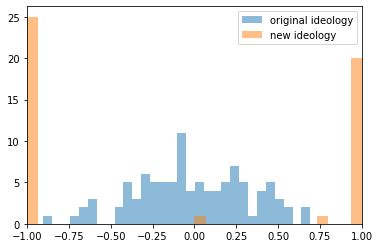

Current ideology mean & standard deviation: -0.089518, 0.981156

After iteration #50:


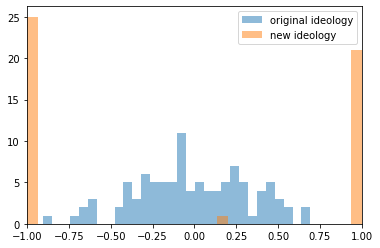

Current ideology mean & standard deviation: -0.081572, 0.986234

After iteration #100:


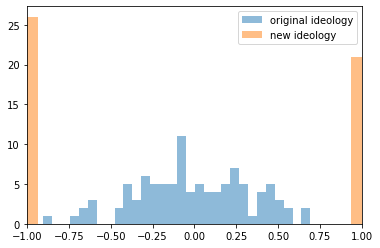

Current ideology mean & standard deviation: -0.106383, 0.994325

53 users have left

=== 4: recommend_n_accordingly ===
After iteration #20:


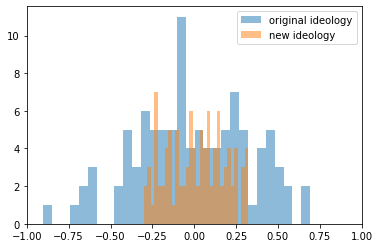

Current ideology mean & standard deviation: 0.012715, 0.171238

After iteration #50:


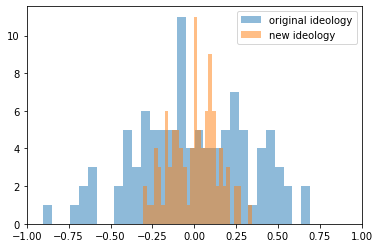

Current ideology mean & standard deviation: -0.002678, 0.141828

After iteration #100:


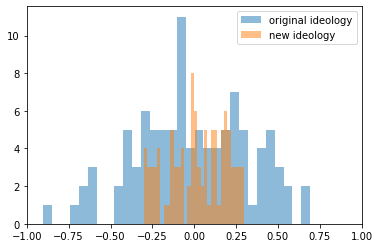

Current ideology mean & standard deviation: 0.016383, 0.168789

0 users have left

*********** Simulating 300 users ***********


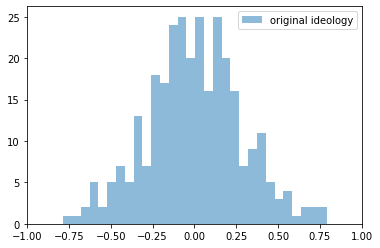

Original ideology mean & standard deviation: 0.000699, 0.283201

=== 1: recommend_n_by_user_post ===
After iteration #20:


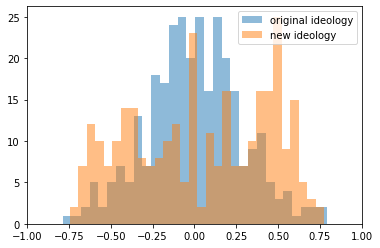

Current ideology mean & standard deviation: 0.037305, 0.406158

After iteration #50:


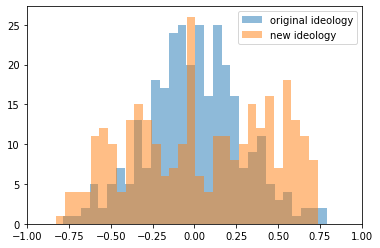

Current ideology mean & standard deviation: 0.042645, 0.415529

After iteration #100:


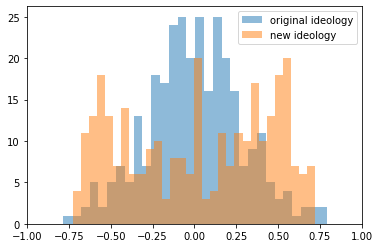

Current ideology mean & standard deviation: 0.017771, 0.428971

0 users have left

=== 2: recommend_n_random ===
After iteration #20:


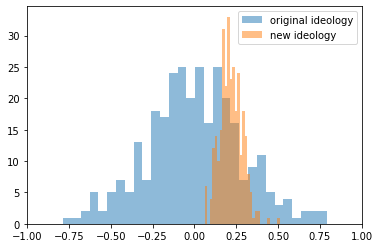

Current ideology mean & standard deviation: 0.217671, 0.067177

After iteration #50:


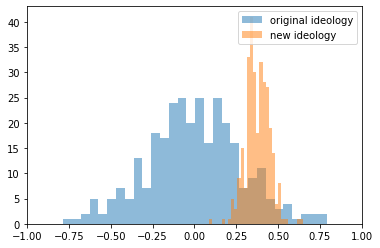

Current ideology mean & standard deviation: 0.378073, 0.071135

After iteration #100:


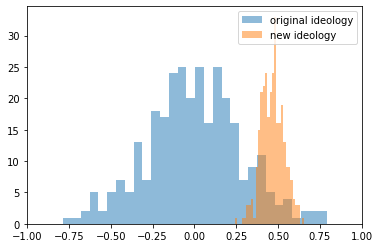

Current ideology mean & standard deviation: 0.465729, 0.066945

0 users have left

=== 3: recommend_n_opposite ===
After iteration #20:


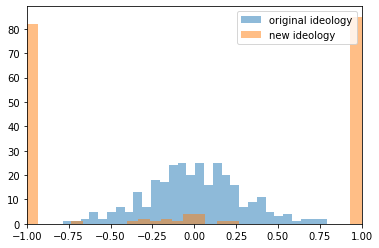

Current ideology mean & standard deviation: 0.006068, 0.953116

After iteration #50:


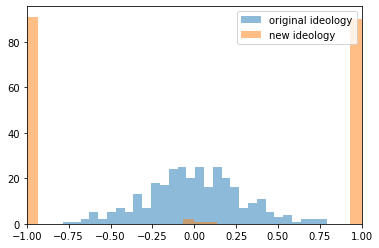

Current ideology mean & standard deviation: -0.005259, 0.989140

After iteration #100:


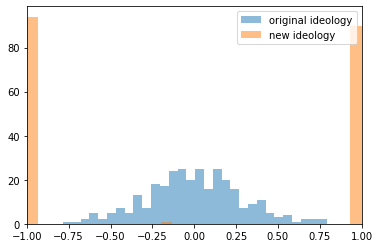

Current ideology mean & standard deviation: -0.022603, 0.997127

115 users have left

=== 4: recommend_n_accordingly ===
After iteration #20:


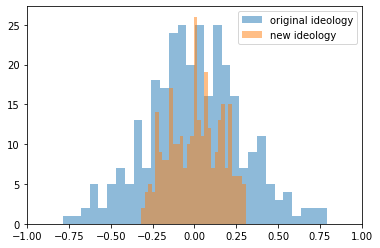

Current ideology mean & standard deviation: 0.008097, 0.153066

After iteration #50:


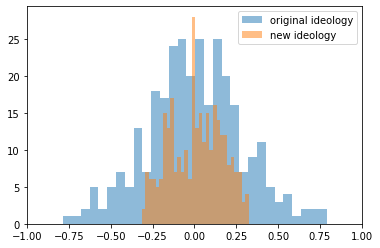

Current ideology mean & standard deviation: 0.012074, 0.154248

After iteration #100:


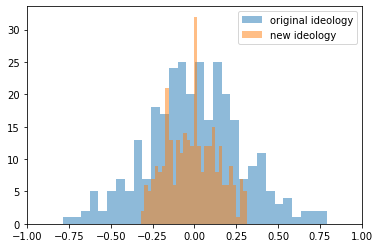

Current ideology mean & standard deviation: -0.011083, 0.150548

0 users have left

*********** Simulating 1000 users ***********


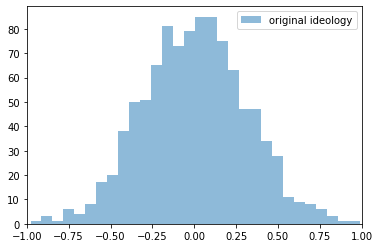

Original ideology mean & standard deviation: 0.005552, 0.304941

=== 1: recommend_n_by_user_post ===
After iteration #20:


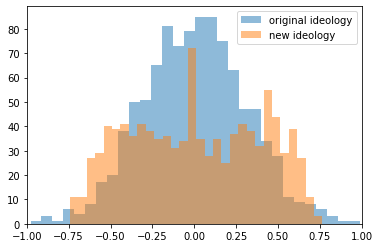

Current ideology mean & standard deviation: 0.011201, 0.385165

After iteration #50:


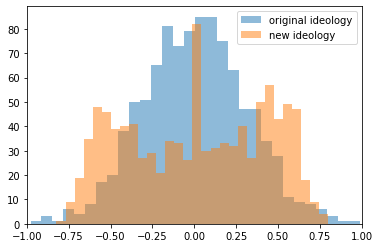

Current ideology mean & standard deviation: 0.012026, 0.414685

After iteration #100:


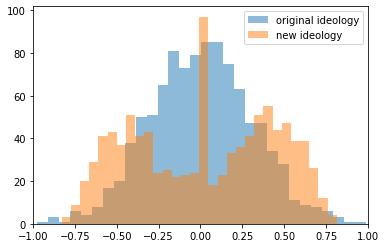

Current ideology mean & standard deviation: 0.019063, 0.419452

0 users have left

=== 2: recommend_n_random ===
After iteration #20:


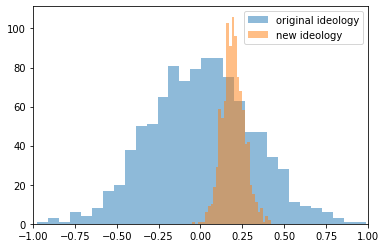

Current ideology mean & standard deviation: 0.195644, 0.066191

After iteration #50:


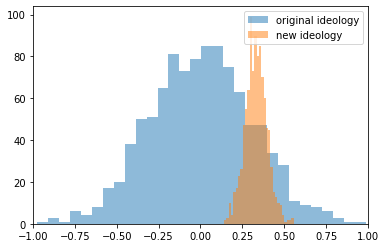

Current ideology mean & standard deviation: 0.332050, 0.065320

After iteration #100:


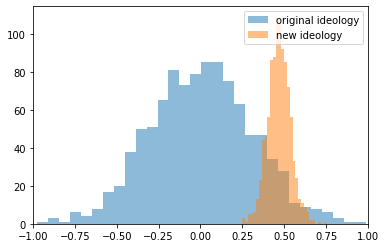

Current ideology mean & standard deviation: 0.469358, 0.067697

0 users have left

=== 3: recommend_n_opposite ===
After iteration #20:


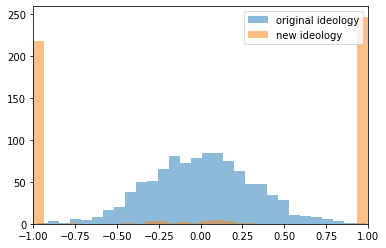

Current ideology mean & standard deviation: 0.056158, 0.975083

After iteration #50:


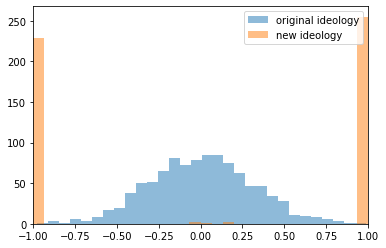

Current ideology mean & standard deviation: 0.053835, 0.993489

After iteration #100:


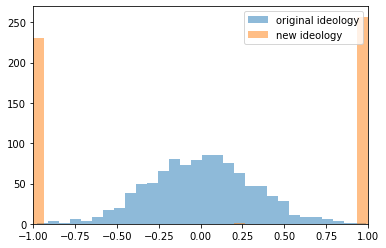

Current ideology mean & standard deviation: 0.053648, 0.997592

511 users have left

=== 4: recommend_n_accordingly ===
After iteration #20:


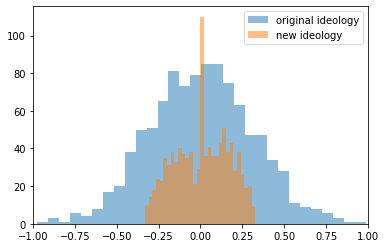

Current ideology mean & standard deviation: 0.008368, 0.160974

After iteration #50:


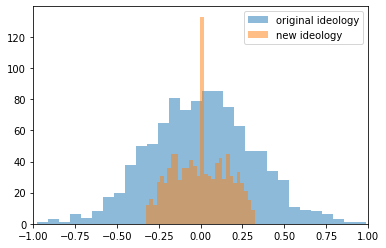

Current ideology mean & standard deviation: -0.002585, 0.157321

After iteration #100:


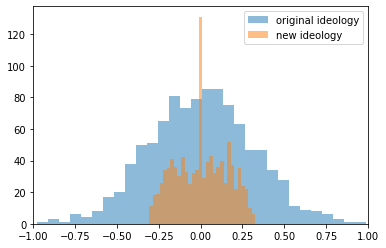

Current ideology mean & standard deviation: 0.005265, 0.153618

0 users have left



In [21]:
from copy import deepcopy

#### def run_simulation(num_iterations):
num_iterations = 100
n_users_list = [100, 300, 1000]

# Generate users for the simulation

for n_user in n_users_list:
    print("*********** Simulating %d users ***********" % n_user)
    users_list = create_n_users(n_user)
    users_list_bak = deepcopy(users_list)

    original_user_ideology_list = []
    for cur_user in users_list:
        original_user_ideology_list.append(cur_user.ideology)

    plt.hist(original_user_ideology_list, 30, alpha=0.5, label='original ideology')
    plt.legend(loc='upper right')
    plt.xlim(-1, 1)
    plt.show()                
    print("Original ideology mean & standard deviation: %f, %f" %
          (np.mean(original_user_ideology_list), np.std(original_user_ideology_list)))    
    print()

    #recommended_posts = {}


    n_recommend_posts = 5

    # 4 types of recommendation strategies
    for t in range(4):
        if (t == 0):
            print("=== 1: recommend_n_by_user_post ===")
        elif (t == 1):
            print("=== 2: recommend_n_random ===")
        elif (t == 2):
            print("=== 3: recommend_n_opposite ===")
        elif (t == 3):
            print("=== 4: recommend_n_accordingly ===")

        users_list = deepcopy(users_list_bak)

        num_users_left = 0
        for i in range(num_iterations):
            # Generate posts for this iteration based on list of users  
            posts_list = create_posts(users_list)
            # Recommend posts to each user
            if (t == 0):
                recommended_posts = recommend_n_by_user_post(posts_list, users_list, n_recommend_posts)
            elif (t == 1):
                recommended_posts = recommend_n_random(posts_list, users_list, n_recommend_posts)
            elif (t == 2):
                recommended_posts = recommend_n_opposite(posts_list, users_list, n_recommend_posts)
            elif (t == 3):
                recommended_posts = recommend_n_accordingly(posts_list, users_list, n_recommend_posts)

            new_user_ideology_list = []
            j = 0
            original_j = 0
            while j < len(users_list):
                #print("j = %d" % j)
            #for j in range(len(users_list)):
                #for recommended_post in recommended_posts[j]:
                cur_user = users_list[j]        
                for recommended_post in recommended_posts[cur_user]:
                    #ideo_distance = abs(users_list[j].ideology - recommended_post.ideology)
                    ideo_distance = abs(cur_user.ideology - recommended_post.ideology)
                    if(ideo_distance >= 1.2):
                        users_list[j].bad_posts += 1
                    elif(ideo_distance <= 0.2):
                        users_list[j].bad_posts -= 1

                    users_list[j].ideology = influence(users_list[j], recommended_post)
                    users_list[j].num_posts_read += 1

                if ((users_list[j].bad_posts == users_list[j].max_bad_posts) and 
                    (users_list[j].bad_posts/users_list[j].num_posts_read > users_list[j].tolerance)):
                    #print("One user has left (user's tolerance score = %f; the user has read %d posts)." 
                    #      % (users_list[j].tolerance, users_list[j].num_posts_read))
                    users_list.pop(j)
                    num_users_left += 1
                else:
                    new_user_ideology_list.append(users_list[j].ideology)
                    j += 1

                original_j += 1

            if(i == 19) or (i == 49) or (i==99):
                print("After iteration #%d:" % (i+1))
                #bins = np.linspace(-1, 1, 100)            
                plt.hist(original_user_ideology_list, 30, alpha=0.5, label='original ideology')
                plt.hist(new_user_ideology_list, 30, alpha=0.5, label='new ideology')    
                plt.legend(loc='upper right')
                plt.xlim(-1, 1)
                plt.show()            
                print("Current ideology mean & standard deviation: %f, %f" %
                  (np.mean(new_user_ideology_list), np.std(new_user_ideology_list)))    
                print()

        #return recommended_posts
        #recommended_posts = run_simulation(100)

        print("%d users have left" % num_users_left)
        print("")


*********** Simulating 1000 users ***********


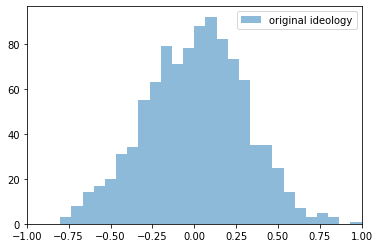

Original ideology mean & standard deviation: 0.007475, 0.297320

=== 1: recommend_n_by_user_post ===
After iteration #20:


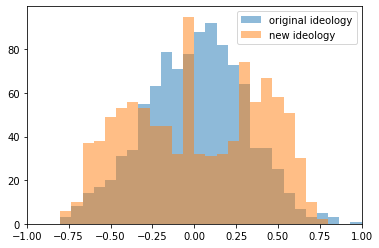

Current ideology mean & standard deviation: 0.011599, 0.390806

After iteration #50:


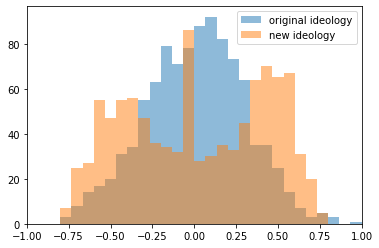

Current ideology mean & standard deviation: 0.021054, 0.417044

After iteration #100:


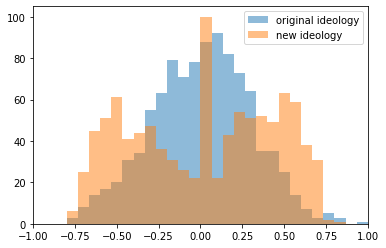

Current ideology mean & standard deviation: 0.016678, 0.421781

0 users have left

=== 2: recommend_n_random ===
After iteration #20:


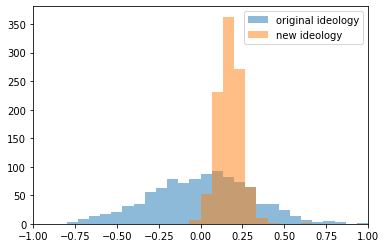

Current ideology mean & standard deviation: 0.171985, 0.070062

After iteration #50:


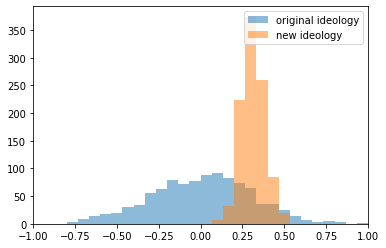

Current ideology mean & standard deviation: 0.311899, 0.069033

After iteration #100:


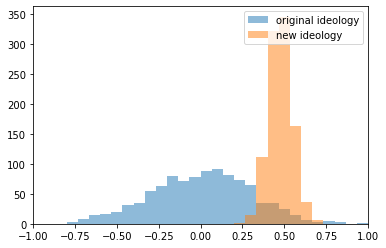

Current ideology mean & standard deviation: 0.476086, 0.068453

0 users have left

=== 3: recommend_n_opposite ===
After iteration #20:


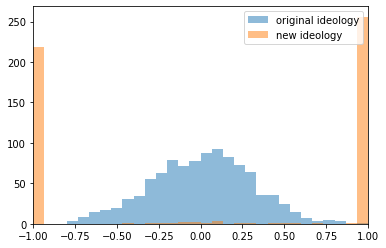

Current ideology mean & standard deviation: 0.079622, 0.978942

After iteration #50:


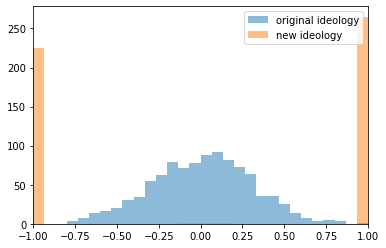

Current ideology mean & standard deviation: 0.081243, 0.991672

After iteration #100:


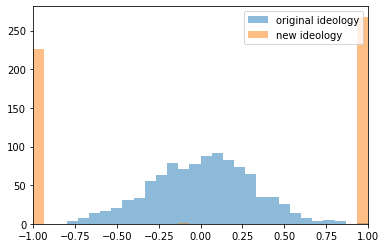

Current ideology mean & standard deviation: 0.084650, 0.995406

505 users have left

=== 4: recommend_n_accordingly ===
After iteration #20:


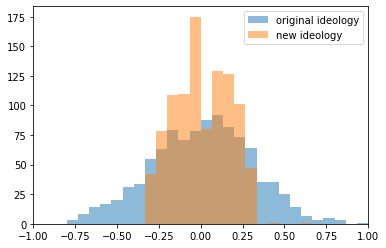

Current ideology mean & standard deviation: 0.012108, 0.163936

After iteration #50:


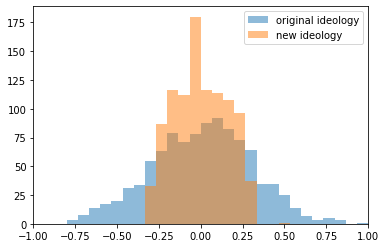

Current ideology mean & standard deviation: 0.003092, 0.158034

After iteration #100:


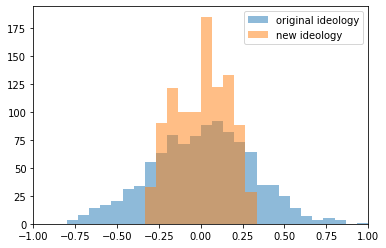

Current ideology mean & standard deviation: 0.002870, 0.156259

0 users have left



In [29]:
from copy import deepcopy

#### def run_simulation(num_iterations):
num_iterations = 100
n_users_list = [100, 300, 1000]

bin_num = 30
bin_range = (-1, 1)

# Generate users for the simulation

for n_user in n_users_list:
    
    if(n_user != 1000):
        continue
    
    print("*********** Simulating %d users ***********" % n_user)
    users_list = create_n_users(n_user)
    users_list_bak = deepcopy(users_list)

    original_user_ideology_list = []
    for cur_user in users_list:
        original_user_ideology_list.append(cur_user.ideology)

    plt.hist(original_user_ideology_list, bin_num, range=bin_range, alpha=0.5, label='original ideology')
    plt.legend(loc='upper right')
    plt.xlim(-1, 1)
    plt.show()                
    print("Original ideology mean & standard deviation: %f, %f" %
          (np.mean(original_user_ideology_list), np.std(original_user_ideology_list)))    
    print()

    #recommended_posts = {}


    n_recommend_posts = 5

    # 4 types of recommendation strategies
    for t in range(4):
        if (t == 0):
            print("=== 1: recommend_n_by_user_post ===")
        elif (t == 1):
            print("=== 2: recommend_n_random ===")
        elif (t == 2):
            print("=== 3: recommend_n_opposite ===")
        elif (t == 3):
            print("=== 4: recommend_n_accordingly ===")

        users_list = deepcopy(users_list_bak)

        num_users_left = 0
        for i in range(num_iterations):
            # Generate posts for this iteration based on list of users  
            posts_list = create_posts(users_list)
            # Recommend posts to each user
            if (t == 0):
                recommended_posts = recommend_n_by_user_post(posts_list, users_list, n_recommend_posts)
            elif (t == 1):
                recommended_posts = recommend_n_random(posts_list, users_list, n_recommend_posts)
            elif (t == 2):
                recommended_posts = recommend_n_opposite(posts_list, users_list, n_recommend_posts)
            elif (t == 3):
                recommended_posts = recommend_n_accordingly(posts_list, users_list, n_recommend_posts)

            new_user_ideology_list = []
            j = 0
            original_j = 0
            while j < len(users_list):
                #print("j = %d" % j)
            #for j in range(len(users_list)):
                #for recommended_post in recommended_posts[j]:
                cur_user = users_list[j]        
                for recommended_post in recommended_posts[cur_user]:
                    #ideo_distance = abs(users_list[j].ideology - recommended_post.ideology)
                    ideo_distance = abs(cur_user.ideology - recommended_post.ideology)
                    if(ideo_distance >= 1.2):
                        users_list[j].bad_posts += 1
                    elif(ideo_distance <= 0.2):
                        users_list[j].bad_posts -= 1

                    users_list[j].ideology = influence(users_list[j], recommended_post)
                    users_list[j].num_posts_read += 1

                if ((users_list[j].bad_posts == users_list[j].max_bad_posts) and 
                    (users_list[j].bad_posts/users_list[j].num_posts_read > users_list[j].tolerance)):
                    #print("One user has left (user's tolerance score = %f; the user has read %d posts)." 
                    #      % (users_list[j].tolerance, users_list[j].num_posts_read))
                    users_list.pop(j)
                    num_users_left += 1
                else:
                    new_user_ideology_list.append(users_list[j].ideology)
                    j += 1

                original_j += 1

            if(i == 19) or (i == 49) or (i==99):
                print("After iteration #%d:" % (i+1))
                #get the bin edges
                bins=np.histogram(np.hstack((original_user_ideology_list,new_user_ideology_list)), bins=30)[1] 
                
                plt.hist(original_user_ideology_list, bin_num, range=bin_range, alpha=0.5, label='original ideology')
                plt.hist(new_user_ideology_list, bin_num, range=bin_range, alpha=0.5, label='new ideology')    
                plt.legend(loc='upper right')
                plt.xlim(-1, 1)
                plt.show()            
                print("Current ideology mean & standard deviation: %f, %f" %
                  (np.mean(new_user_ideology_list), np.std(new_user_ideology_list)))    
                print()

        #return recommended_posts
        #recommended_posts = run_simulation(100)

        print("%d users have left" % num_users_left)
        print("")
